# GIS 712: Environmental Earth Observation and Remote Sensing  
## Image classification using Scikit-learn 

<img src="imgs/deeplearning.png" width="650">  


Image classification using the [Flaveland, NL dataset](https://earth.esa.int/web/polsarpro/data-sources/sample-datasets). 

Source: [Deep Learning in Remote Sensing: A Comprehensive Review and List of Resources](https://ieeexplore.ieee.org/document/8113128).

### Why Scikit-learn?

In this in-class data exercise and HW we will focus on classification, one of the most common topics in remote sensing. We will be using the [scikit-learn library](https://scikit-learn.org/stable/).  

This library provides easy interfaces to many of the most commonly used machine learning algorithms. Scikit-learn is built on top of the pre-existing scientific Python libraries (e.g. numpy, matplotlib), making it very easy to incorporate into our workflows. 

### Loading the necessary libraries

In [1]:
import os
import rasterio
from rasterio.plot import show
import numpy as np
import matplotlib.pyplot as plt

We will work with one of the Sentinel images we used in the raster in python in-class data exercise also copied again in your data subfolder for today.

In [2]:
# get current working directory
os.getcwd()

'c:\\Users\\cblim\\Documents\\NCSU\\Courses\\GIS712\\code\\Lectures\\Lecture05\\classification'

In [3]:
# os.path.join with cwd and data/s2_20190831
s2_folder = os.path.join(os.getcwd(), "data", "s2_20190831")
print("s2_folder is: ", s2_folder) # check we're in the right location

s2_folder is:  c:\Users\cblim\Documents\NCSU\Courses\GIS712\code\Lectures\Lecture05\classification\data\s2_20190831


### Unsupervised Classification: K-means clustering
Let's first try an unsupervised classification algorithm, namely k-means clustering. In the scikit-learn library, k-means clustering aims to partition "n" observations into "k" clusters in which each observation belongs to the cluster with the nearest mean.

If you need to install Scikit-learn, here are two ways that you can do it:

1. - Open your anaconda prompt
    - Activate your environment (In this case, the GIS712 environment) by typing:  

        $ conda activate GIS712

    - Install Scikit-learn using conda forge, type:

        $ conda install -c conda-forge scikit-learn  

    - Restart your python kernel

2. Another way is to add scikit-learn to your current GIS712.yml and then update your environment:
conda env update --name GIS712 -f GIS712.yml

In [4]:
from sklearn import cluster
# let's start by working w/ a single band, namely the blue band
band = rasterio.open(os.path.join(s2_folder, 'T18SVE_20190831T153911_B02.jp2')) # open the data set
blue = band.read(1) # read it in as a numpy array
print(blue.shape, blue.dtype, type(blue))

(10980, 10980) uint16 <class 'numpy.ndarray'>


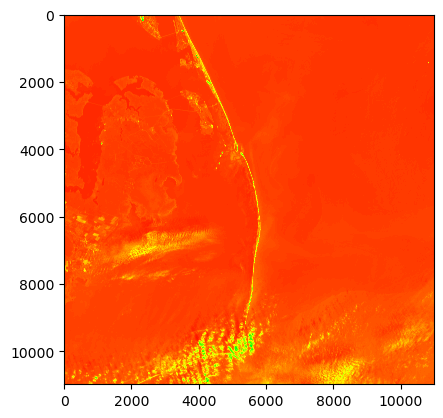

<Axes: >

In [5]:
# let's plot the band
show(blue, cmap = "hsv") #set a color map https://matplotlib.org/examples/color/colormaps_reference.html

The image is too large to run the classification, so let's subset it first!

(700, 600)


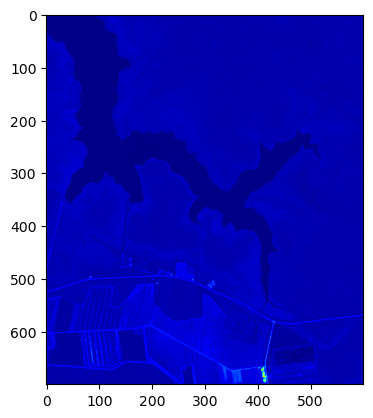

<Axes: >

In [6]:
# clipping img by slicing the np.array
clipped_blue = blue[2500:3200:, 1800:2400]
print(clipped_blue.shape)
show(clipped_blue, cmap = "jet") 

To use the classifier & for the classifier to accept the data we need to reshape this array. In scikit-learn, some estimators (e.g., classifiers and regressors) and preprocessing methods expect the input feature array X to be a 2D array with one column. We will use the command .reshape(-1,1), which means we want to flatten the data into the rows and keep the columns as 1 (we're looking at one band). So our resulting array takes the form (rows, 1) for the blue band reshaped.

The .reshape(-1, 1) method in NumPy (or similar libraries that offer array manipulation) is often used to change the shape of an array. Specifically, it changes the array into a 2D array with one column. The "-1" is used as a placeholder for an unknown dimension that should be inferred from the length of the array. To see how it works you cantry: a = np.array([1, 2, 3, 4, 5])
and then a_reshaped = a.reshape(-1, 1)


In [7]:
reshaped_blue = clipped_blue.reshape(-1,1)

In [8]:
print(reshaped_blue.shape, reshaped_blue.dtype, type(reshaped_blue))

(420000, 1) uint16 <class 'numpy.ndarray'>


**Note**: the number of rows above 420000 comes from the array of 700 rows and 600 columns (see results above) being reshaped into 700*600 = 420000 rows 

Now we can run the k-means classifier on our data. First of all we need to choose how many clusters; let's try with 5 clusters. 

In [9]:
# from the module cluster we've imported above (from sklearn import cluster), 
# we use the KMeans classifier with 5 clusters and assign it to a variable called k_means
k_means = cluster.KMeans(n_clusters=5) 

In [10]:
# Then we can fit the classification to the reshaped band data.
k_means.fit(reshaped_blue)

KMeans(n_clusters=5)

After we fit the k_means, we want to know the labels each data point belongs to.
The `k_means.labels_` attribute in scikit-learn provides the labels of the clusters that each data point belongs to, 
after you've fit the K-means algorithm on your data. 
Specifically, it's a 1D NumPy array where the i-th element is the cluster index to which the i-th data point in the input array X belongs.

In [11]:
# assigning the results of this fitting to a new variable called reshaped_blue_cluster
# labels_ ndarray of shape (n_samples,)
# Labels of each point
reshaped_blue_cluster = k_means.labels_ 
print(type(reshaped_blue_cluster))
print(reshaped_blue_cluster)
print(reshaped_blue_cluster.shape)

<class 'numpy.ndarray'>
[2 2 2 ... 0 0 1]
(420000,)


In [12]:
# After the labels have been assigned we then need to reshape this result back to the dimensions of the original image.
reshaped_blue_cluster = reshaped_blue_cluster.reshape(clipped_blue.shape)
print(reshaped_blue_cluster.shape, reshaped_blue_cluster.dtype, type(reshaped_blue_cluster))

(700, 600) int32 <class 'numpy.ndarray'>


Let's see what the results look like, it doesn't look too bad esp given that we're looking at one single band.

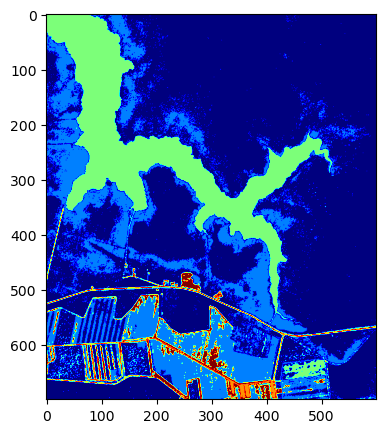

In [13]:
plt.figure(figsize=(5,5))
plt.imshow(reshaped_blue_cluster, cmap="jet") #set a color map https://matplotlib.org/examples/color/colormaps_reference.html
plt.show()

As you may recall, Sentinel 2 has 13 bands of 3 resolutions, 10m, 20m, and 60m. So, we'll want to run a classification on all the bands. A stack of all bands @10m is in your data folder s2_stack_20190831.tif

let's open up the data and read in the stack as a numpy array

In [15]:
print(os.getcwd())
s2_stack_file_path = os.path.join(os.getcwd(), 'data', s2_folder, 's2_stack_2019083.tif')
print(s2_stack_file_path)
os.path.isfile(s2_stack_file_path) # if this yields 'False' the you've got a path issue

c:\Users\cblim\Documents\NCSU\Courses\GIS712\code\Lectures\Lecture05\classification
c:\Users\cblim\Documents\NCSU\Courses\GIS712\code\Lectures\Lecture05\classification\data\s2_20190831\s2_stack_2019083.tif


True

In [16]:
s2_bands = rasterio.open(s2_stack_file_path)
# s2_bands = rasterio.open(os.path.join(os.getcwd(), 'data', s2_folder, 's2_stack_2019083.tif'))
s2_stack = s2_bands.read()
print(s2_stack.shape, s2_stack.dtype, type(s2_stack)) # you can see that now we have 13 bands

(13, 10980, 10980) uint16 <class 'numpy.ndarray'>


In [17]:
# We need to clipsubset it, otherwise it'll take too long to run
clipped_s2_stack = s2_stack[:, 2500:3200:, 1800:2400]
print(clipped_s2_stack.shape) # note below that we now have 13 bands, 700 rows and 600 columns

(13, 700, 600)


In [18]:
# same as above just making the names intuitive
bands, rows, cols = clipped_s2_stack.shape
print("bands:", bands, "rows:", rows, "cols: ", cols)

bands: 13 rows: 700 cols:  600


We need to reshape the stack as before to have rows, cols, bands, we're using the `reshape_as_image` function.  

"`reshape_as_image`: *Returns the source array reshaped into the order expected by image processing and visualization software (matplotlib, scikit-image, etc) by swapping the axes order from (bands, rows, columns) to (rows, columns, bands)*"


In [19]:
# import reshape_as_image
from rasterio.plot import reshape_as_image
reshaped_s2_stack = reshape_as_image(clipped_s2_stack)
print(reshaped_s2_stack.shape, type(reshaped_s2_stack))

(700, 600, 13) <class 'numpy.ndarray'>


We're now applying the same k_means code we applied to band 2 (i.e. the blue) before, the code is identical, the only difference being the file names

In [20]:
k_means = cluster.KMeans(n_clusters=5)

We need to reshape again as before but now instead of .reshape(-1, 1) we use .reshape(-1, 13) bc we have 13 bands!
thus 13-feature vectors, and you want to reshape it into a 2D array where each row is a 13-dimensional feature vector.

In [21]:
kmeans_predictions = k_means.fit(reshaped_s2_stack.reshape(-1, 13))

In [22]:
# reshape the array to what it was before
kmeans_predictions_2d = kmeans_predictions.labels_.reshape(rows, cols) 
print(kmeans_predictions_2d.shape, type(kmeans_predictions_2d))

(700, 600) <class 'numpy.ndarray'>


In [23]:
# define function to stretch the color for better viz
# This function performs a "color stretch" on an input image 
# for the specified bands (indexed by index). 
# A color stretch enhances the visual contrast of an image
#  by redistributing its pixel values. This is often useful for 
# improving the visualization of features in satellite or aerial imagery.

# The `rasterio.plot.adjust_band`` function is used to perform the actual 
# color stretch on each band. This could involve redistributing 
# the pixel values for better contrast and visibility.
def color_stretch(image, index):
    colors = image[:, :, index].astype(np.float64)
    # print('colors is ', colors)
    for b in range(colors.shape[2]):
        # print('colors.shape[2] is ', colors.shape[2])
        colors[:, :, b] = rasterio.plot.adjust_band(colors[:, :, b])
    return colors

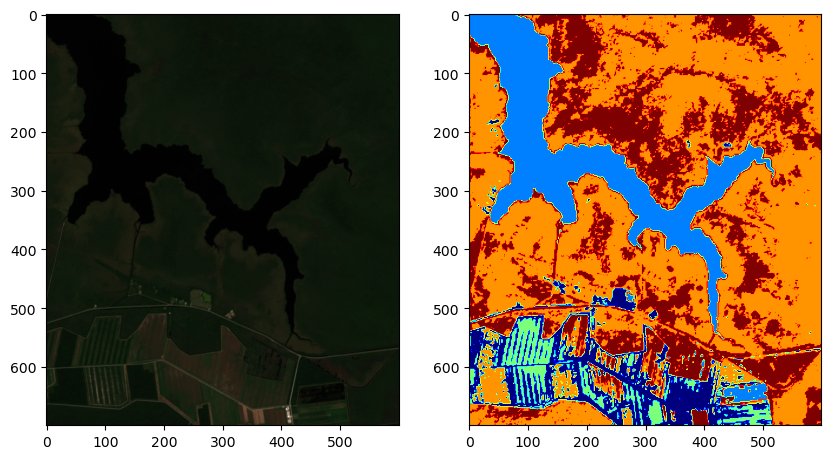

In [24]:
# Plot the classmap next to the true color image
fig, axs = plt.subplots(1,2,figsize=(10,8))

img_stretched = color_stretch(reshaped_s2_stack, [3, 2, 1])
axs[0].imshow(img_stretched)

axs[1].imshow(kmeans_predictions_2d, cmap = 'jet')

Fell free to play around with more/fewer clusters and have a read through the scikit-learn [documentation for K-means](https://scikit-learn.org/stable/modules/clustering.html).

### Supervised Classification: Random Forest (RF)  

Now let's try one of the most commonly used machine-learning supervised classifications, namely Random Forest (RF).  

As a quick reminder of what RF is from today's reading [Maxwell et al 2018](https://www.tandfonline.com/doi/full/10.1080/01431161.2018.1433343).

RF is an ensemble classifier, which uses a large number of decision trees (DTs) thus overcoming the weaknesses of a single DT. It then uses the majority ‘vote’ of all the trees to assign a final class for each unknown sample. By averaging many trees, a global optimum should be obtained. The random part of RF comes from training each tree with its own randomly generated subset of the training data, and also only using a subset of the variables for that tree. 

The combination of reduced training data and reduced number of variables generates trees that are less accurate, but they will also be less correlated, making the ensemble as a whole more reliable. 

The data not used in training are known as the out of bag (OOB) data and can be used to provide an independent estimate of the overall accuracy of the RF classification. 

By comparing the performance of the trees that use a specific variable/feature, and those that don’t, the relative importance of each variable/feature can be evaluated. 

By multiple trees in RF, the individual trees don't need to be pruned as with DT classification. However, this results in not being able to visualize the trees. 


For a supervised classification we need some training data. I've created a shapefile with some training data for the Alligator River area that we subsettted to before. The shapefile is in your /data subfolder and is called "ar_landcover_training.shp".  

If you want to improve this classification, you could add more training data to this shapefile or create a new shapefile.

You can do this in QGIS using the following tutorial on [how to create polygons](https://docs.qgis.org/2.8/en/docs/training_manual/create_vector_data/create_new_vector.html).

Take a moment to load up the s2_stack_20190831.tif and ar_landcover_training.shp into QGIS and have a look at the layer properties and Attribute Table.

In [25]:
import geopandas as gpd
shapefile = gpd.read_file(os.path.join('data', 'ar_landcover_training.shp'))
shapefile.head() # top 5 rows
# shapefile.tail() # bottom 5 rows

,id,ClassName,ClassValue,geometry
0,1,Water,1,"POLYGON ((417414.250 3975065.683, 417785.066 3..."
1,2,Water,1,"POLYGON ((418703.278 3974147.471, 418915.173 3..."
2,3,Water,1,"POLYGON ((418777.722 3972174.639, 418924.883 3..."
3,4,Water,1,"POLYGON ((419450.629 3971905.239, 419747.325 3..."
4,5,Water,1,"POLYGON ((419583.549 3972619.683, 419659.503 3..."


Our training data contains a ClassName field (String datatype), which we'll used for pairing labels from these polygons with the information in our raster. For this we will use the `rasterio mask` function which takes in a *raster dataset and a polygon and outputs a numpy array with the pixel values within the polygons.*

But we first need to save the geometry of the polygons as geojson before applying this function.

We also need to make sure that the polygon shapefile and raster are co-aligned in space (i.e. have the same projection), so we query this below:


In [26]:
s2_bands.crs

CRS.from_epsg(32618)

In [27]:
shapefile.crs

<Projected CRS: EPSG:32618>
Name: WGS 84 / UTM zone 18N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 78°W and 72°W, northern hemisphere between equator and 84°N, onshore and offshore. Bahamas. Canada - Nunavut; Ontario; Quebec. Colombia. Cuba. Ecuador. Greenland. Haiti. Jamaica. Panama. Turks and Caicos Islands. United States (USA). Venezuela.
- bounds: (-78.0, 0.0, -72.0, 84.0)
Coordinate Operation:
- name: UTM zone 18N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [28]:
len(shapefile) # how many polygon features in our shapefile?

10

In [29]:
# We extract the geometry of each feature in the shapefile in GeoJSON format, which generates a list of shapely geometries
geoms = shapefile.geometry.values 

# check one of these geometries
geometry = geoms[0] 
print(type(geometry))
print(geometry)

# transform to GeoJSON format
from shapely.geometry import mapping
feature = [mapping(geometry)] 
print(type(feature))
print(feature)
print(len(feature))

<class 'shapely.geometry.polygon.Polygon'>
POLYGON ((417414.2500931308 3975065.682997403, 417785.0664179695 3975436.499322242, 418261.8302641907 3975136.314678325, 417414.2500931308 3975065.682997403))
<class 'list'>
[{'type': 'Polygon', 'coordinates': (((417414.2500931308, 3975065.682997403), (417785.06641796953, 3975436.4993222416), (418261.83026419074, 3975136.314678325), (417414.2500931308, 3975065.682997403)),)}]
1


Now let's extract the raster values within the polygon using the rasterio mask() function

In [30]:
from rasterio.mask import mask
out_image, out_transform = mask(s2_bands, feature, crop=True)
# out_image.shape 

In [31]:
s2_bands.close() # close the rasterio data set

### Building the Training Data for scikit-learn  

Now let's do it for all features in the shapefile and create an array X that has all the pixels and an array y that has all the training labels.

In [32]:
X = np.array([], dtype=np.int8).reshape(0,13) # pixels for training
y = np.array([], dtype=np.string_) # labels for training

In [33]:
# extract the raster values within the polygon 
with rasterio.open(os.path.join(s2_folder, 's2_stack_2019083.tif')) as src:
    band_count = src.count
    for index, geom in enumerate(geoms):
        feature = [mapping(geom)]

        # the mask function returns an array of the raster pixels within this feature
        out_image, out_transform = mask(src, feature, crop=True) 
        # eliminate all the pixels with 0 values for all bands (not part of the shapefile)
        out_image_trimmed = out_image[:,~np.all(out_image == 0, axis=0)]
        # eliminate all the pixels with 255 values for all bands (not actually part of the shapefile)
        out_image_trimmed = out_image_trimmed[:,~np.all(out_image_trimmed == 255, axis=0)]
        # reshape the array to [pixel count, bands]
        out_image_reshaped = out_image_trimmed.reshape(-1, band_count)
        # append the labels to the y array
        y = np.append(y,[shapefile["ClassName"][index]] * out_image_reshaped.shape[0]) 
        # stack the pixels onto the pixel array
        X = np.vstack((X,out_image_reshaped))   

In [34]:
X # the "X" matrix containing our features (values under the polygons in the 13 bands)

array([[1138, 1138, 1138, ..., 1138, 1138, 1138],
       [1138, 1138, 1138, ..., 1138, 1138, 1138],
       [1138, 1137, 1137, ..., 1138, 1138, 1138],
       ...,
       [2388, 2388, 2558, ..., 2468, 2486, 2486],
       [2388, 2544, 2433, ..., 2443, 2433, 2433],
       [2433, 2438, 2438, ..., 2415, 2415, 2431]], dtype=int32)

In [35]:
y # the "y" array containing our labels

array(['Water', 'Water', 'Water', ..., 'NonWater', 'NonWater', 'NonWater'],
      dtype='<U8')

In [36]:
# What are our classification labels?
labels = np.unique(shapefile["ClassName"])
print(f'The training data include {labels.size} classes: {labels}\n')
print(f'Our X matrix is sized: {X.shape}')
print(f'Our y array is sized: {y.shape}')

The training data include 2 classes: ['NonWater' 'Water']

Our X matrix is sized: (51380, 13)
Our y array is sized: (51380,)


In [37]:
# quick helper function to convert the class labels into indices and assign a dictionary relating the class indices to their names
def str_class_to_int(class_array):
    class_array[class_array == 'Water'] = 1
    class_array[class_array == 'NonWater'] = 2
    return(class_array.astype(int))

### Training the RF Classifier

Now that we have our X matrix of feature inputs (the spectral bands) and our y array (the labels), we can train our model.

In [38]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
# test_size = 0.25 >> i.e. 25% of the data; represents the proportion of the dataset to include in the test split
train_features, test_features, train_labels, test_labels = train_test_split(X, y, test_size = 0.25, random_state = 8) 
# The random_state parameter in the train_test_split function from scikit-learn 
# is used for initializing the internal random number generator, 
# which will decide the splitting of data into train and test indices. 
# Providing a specific number (e.g., 8) as a seed makes the randomization deterministic. 
# In other words, the random split will produce the same result each time you run it with random_state=8.

In [39]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)
# 12845+38535 = 51380

Training Features Shape: (38535, 13)
Training Labels Shape: (38535,)
Testing Features Shape: (12845, 13)
Testing Labels Shape: (12845,)


In [40]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier
# Instantiate model with 100 decision trees
rf = RandomForestClassifier(n_estimators = 100, random_state = 8)
# Fit the model on training data
rf.fit(train_features, train_labels)

RandomForestClassifier(random_state=8)

In [41]:
# predict on the clipped and reshaped image, go back to WHAT WE DID above as a reminder as to why we reshape the band
class_prediction = rf.predict(reshaped_s2_stack.reshape(-1, 13)) 

In [42]:
# Reshape our classification map back into a 2D matrix so we can visualize it
class_prediction = class_prediction.reshape(reshaped_s2_stack[:, :, 0].shape)

In [43]:
class_prediction

array([['Water', 'Water', 'Water', ..., 'NonWater', 'NonWater',
        'NonWater'],
       ['Water', 'Water', 'Water', ..., 'NonWater', 'NonWater',
        'NonWater'],
       ['Water', 'Water', 'Water', ..., 'NonWater', 'NonWater',
        'NonWater'],
       ...,
       ['NonWater', 'NonWater', 'NonWater', ..., 'NonWater', 'NonWater',
        'NonWater'],
       ['NonWater', 'NonWater', 'NonWater', ..., 'NonWater', 'NonWater',
        'NonWater'],
       ['NonWater', 'NonWater', 'NonWater', ..., 'NonWater', 'NonWater',
        'NonWater']], dtype='<U8')

In [44]:
# apply str_class_to_int
class_prediction = str_class_to_int(class_prediction)

In [45]:
class_prediction

array([[1, 1, 1, ..., 2, 2, 2],
       [1, 1, 1, ..., 2, 2, 2],
       [1, 1, 1, ..., 2, 2, 2],
       ...,
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2]])

In [46]:
class_prediction.shape

(700, 600)

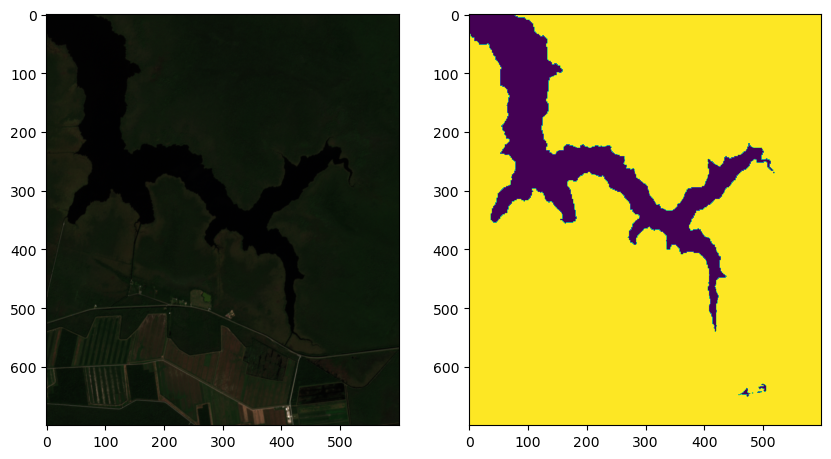

In [47]:
# Let's look at the results
fig, axs = plt.subplots(1,2,figsize=(10,8))

img_stretched = color_stretch(reshaped_s2_stack, [3, 2, 1])
axs[0].imshow(img_stretched)

axs[1].imshow(class_prediction)

In [48]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
print(importances)

[0.05631656835178945, 0.05001451777906321, 0.047747332882867, 0.0429358220517995, 0.053872767920105605, 0.07361424323827237, 0.11489980121082934, 0.08902393635990466, 0.07732712566749293, 0.08302710340482866, 0.08652036395105898, 0.11589443505828602, 0.10880598212370232]


Remember we had 13 bands as input features to the classification and each one is given an importance value in predicting the classes water/nonwater, the higher the number the better that features is as a predictor.

In [59]:
# Let's format the array for better viz
import pandas as pd

# band names
band_names = range(1,14,1)
df = pd.DataFrame({'Band':list(range(1,14,1)),'RF_Importance':importances}).sort_values(by=['RF_Importance'], ascending=False)
df

,Band,RF_Importance
11,12,0.115894
6,7,0.114900
12,13,0.108806
7,8,0.089024
10,11,0.086520
9,10,0.083027
8,9,0.077327
5,6,0.073614
0,1,0.056317
4,5,0.053873


In [50]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix

In [51]:
print(rf.classes_[0])
print(rf.classes_[1])

NonWater
Water


In [52]:
# Predicting the Test set results
y_pred = rf.predict(test_features) # predict the class for the instances in the test set

In [53]:
# Predicting class probabilities
print("Negative Class: ", rf.classes_[0])
print("Positive Class: ", rf.classes_[1])
probs = rf.predict_proba(test_features) # Given an instance in the test set, what is the probability of each class it may fall in
print(probs)

Negative Class:  NonWater
Positive Class:  Water
[[0.83 0.17]
 [1.   0.  ]
 [1.   0.  ]
 ...
 [0.   1.  ]
 [1.   0.  ]
 [0.74 0.26]]


In [54]:
print(confusion_matrix(test_labels, y_pred))

[[11047    29]
 [   44  1725]]


In [55]:
# At the True Negatives, False Positives, False Negatives, True Positives
tp, fp, fn, tn = confusion_matrix(test_labels, y_pred).ravel()
print((tn, fp, fn, tp))

(1725, 29, 44, 11047)


In [56]:
# Accuracy Score
from sklearn.metrics import accuracy_score
print( accuracy_score(test_labels, y_pred) )

0.994316854807318


In [58]:
# Classificaton Report 
from sklearn.metrics import classification_report
print(classification_report(test_labels, y_pred, digits=4))

              precision    recall  f1-score   support

    NonWater     0.9960    0.9974    0.9967     11076
       Water     0.9835    0.9751    0.9793      1769

    accuracy                         0.9943     12845
   macro avg     0.9897    0.9863    0.9880     12845
weighted avg     0.9943    0.9943    0.9943     12845



## Homework 3 (Total of 8 points)

Q1: Which feature/band is the best predictor? Does it make sense given what we know about water spectral signatures? Justify your answer. (2p)

The band that is the best predictor, according to the importance denoted to it by the random forest classifier, is band 12 - a SWIR band. This makes sense as we know the water spectral signature does not respond much/at all in the wavelength the SWIR band operates at; therefore, we could expect that leveraging band 12 to identify where water is and is not may be very useful when performing binary water classification.

Q2: How could we improve the classification accuracy? list at least 3 ways and justify the choice. (3p)
(Hint: Think about the parameters that we can tweak, read Maxwell et al 2018)

1. We could include additional data from different regions to our training & testing data as we are only using a subset of a single image in a single region. This may not necessarily improve our classification accuracy, but it will most likely improve the generalizability of our classifiers. Additionally, we could change the split percentage of our training/testing data to include more training data in fitting our model.

2. We could use a neural network (NN) or convolutional NN (CNN); however, this would most likely require additional data and goes back to point 1 above.

3. In terms of tweaking the RF model: we could increase the number of decision trees being used in the ensemble, changing the criterion used to generate the decision trees which may change the max entropy between each decision tree level resulting in possibly better decision trees, increasing the 'max_features' argument to include additional features every time we generate a decision tree (as currently the number of bands being used for each decision tree is the sqrt(n_bands) and changing the number of features used per decision tree may generate a new random decision tree classifier that performs better than a previous one), using a different random state seed as this randomness may increase the accuracy.


Q3: Describe in your own words what is RF and what are the steps we took to implement the classification in scikit-learn. (3p)

Random Forest (RF) is an ensemble of decision trees where we bootstrap each decision tree with some subset of our training data to determine some decision tree. The randomness comes from the feature combinations we use per decision tree (some subset of our features). Each decision tree is then used to perform classification and the results for each pixel are determined using some aggregation scheme, e.g., taking the mean prediction from each decision tree. The steps we took to implement the classification in scikit-learn are the following: read in the training data and labels, mask the training data with the corresponding label data, convert the training data to the correct shape the features are expected to have to be used by the RF algorithm, split the training data and labels into training and testing data/labels in order to accurately measure performance on our classification method and avoid overfitting, fit the RF algorithm with our training data & labels. We have now trained our RF model to classify water vs non-water pixels, which we need to reshape the predictions to the original image shape. In order to measure the performance, we print the confusion matrix to show the statistics regarding true positives, true negatives, false positives & false negatives; as well as, predicting our testing data and seeing how accurate our algorithm is on these ground-truth labels and let us see if our RF model is overfitting. It would probably be better to use testing data from a different region.